In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
from sklearn.decomposition import PCA
from cond_color import get_colors, plot_start, plot_end

In [3]:
np.random.seed(41)

Loading Data

In [4]:
data_orig = np.load('psths.npz')
X, times = data_orig['X'], data_orig['times']

# Exercise 1: Plotting raw PSTHs

In [5]:
def plot_psths(data, timeintervals, n_rows, n_cols, n_cond):
    np.random.seed(41)
    cond = np.random.randint(low=data.shape[1], size=n_cond)

    fig, ax = plt.subplots(n_rows, n_cols, tight_layout=True, figsize=(8,12))
    for row in ax:
        n = np.random.randint(low=data.shape[0], size=1)[0]
        for c in cond:
            row.plot(timeintervals, data[n, c,:], label = 'Condition = '+str(c))
            row.set_title(f'Neuron {n}')
            row.set_xlabel('Time relative to onset of hand movement')
            row.set_ylabel('Trial-averaged spike rate (Hz)')
            row.legend(loc='upper left', prop={'size': 10})
    return

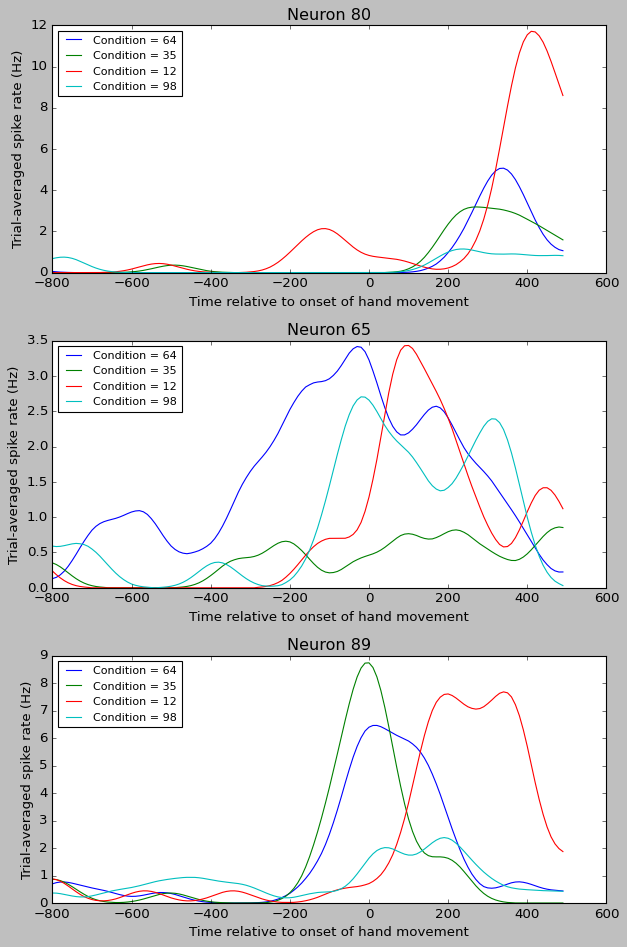

In [6]:
plot_psths(X, times, 3, 1, 4)

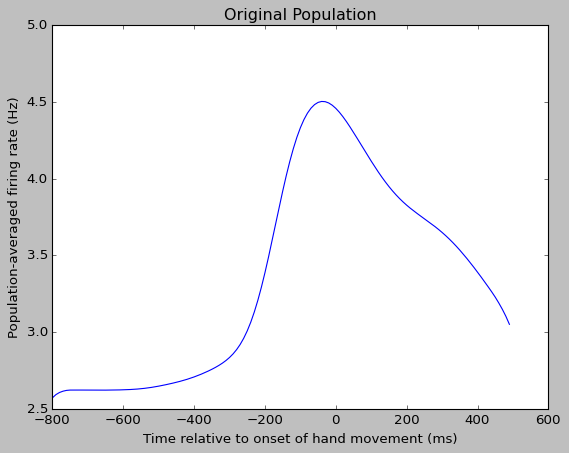

In [7]:
pop_mean = data_orig['X'].mean(axis=(0,1))
plt.plot(times, pop_mean)
plt.title('Original Population')
plt.xlabel('Time relative to onset of hand movement (ms)')
plt.ylabel('Population-averaged firing rate (Hz)')

plt.show()

# Exercise 2: Pre-processing

## Normalisation

In [8]:
def plot_max_hist(data):
    plt.hist(data.max(axis=(1,2)), bins=20)
    plt.title('Histogram of neuron maximum values')
    plt.ylabel('Frequency')
    plt.xlabel('Max value for a given neuron across time and conditions')

    plt.show()
    return

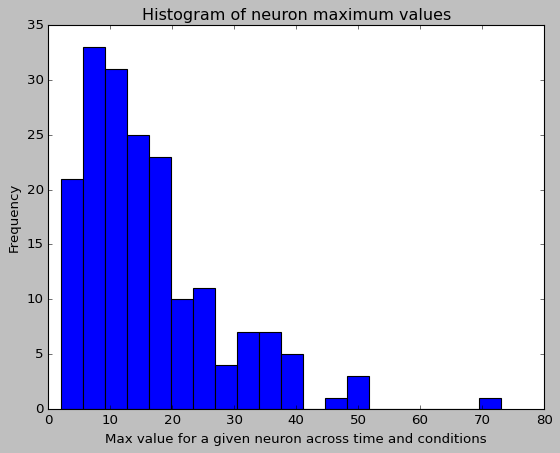

In [9]:
plot_max_hist(X)

In [10]:
def norm_data(data):
    a, b = data.max(axis=(1,2)), data.min(axis=(1,2))
    a, b = a.reshape(data.shape[0],1,1), b.reshape(182,1,1)
    data_normed = (data - b) / (a - b + 5 )

    return data_normed

In [11]:
X_norm = norm_data(X)

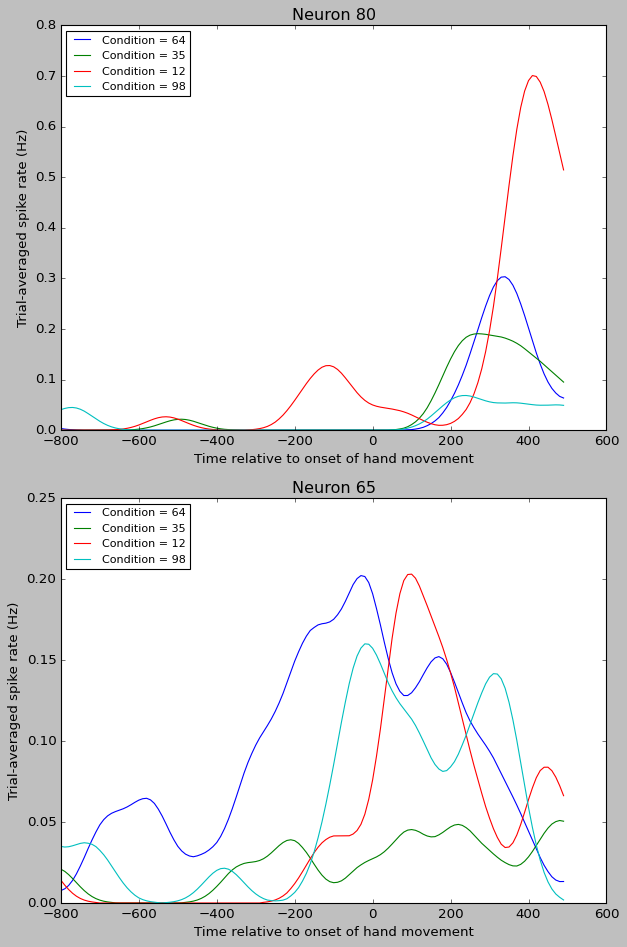

In [12]:
plot_psths(X_norm, times, 2, 1, 4)

## Mean centering

In [13]:
def center_data(data):
    mean = data.mean(axis=(0,2))
    mean = mean.reshape(1, 108, 1)
    data_centered = data - mean
    return data_centered

In [14]:
X_norm_mean = center_data(X_norm)

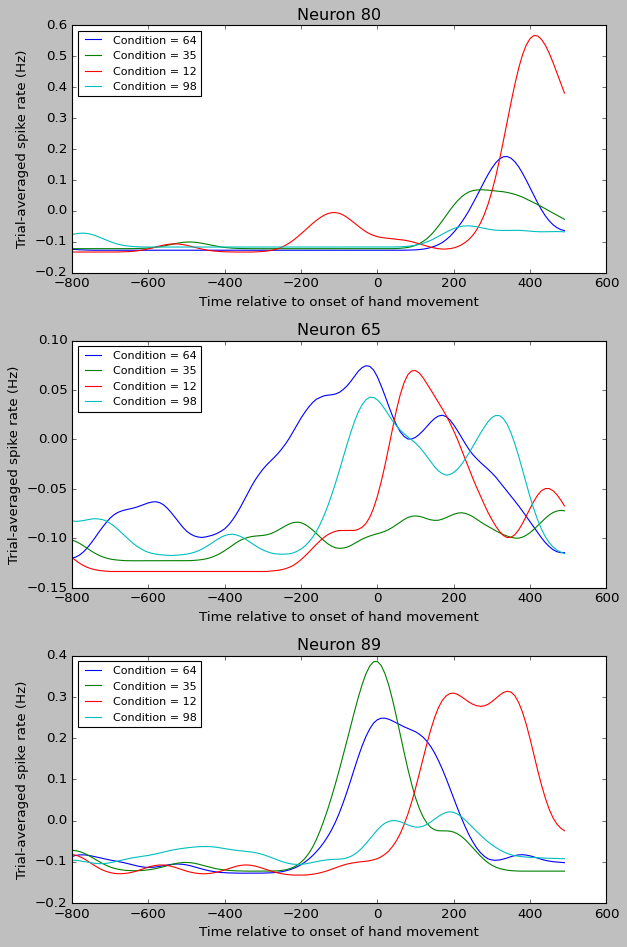

In [15]:
plot_psths(X_norm_mean, times, 3, 1, 4)

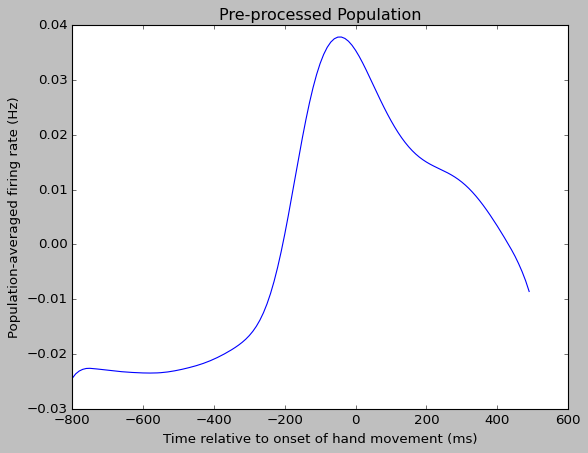

In [16]:
pop_mean = X_norm_mean.mean(axis=(0,1))
plt.plot(times, pop_mean)
plt.title('Pre-processed Population')
plt.xlabel('Time relative to onset of hand movement (ms)')
plt.ylabel('Population-averaged firing rate (Hz)')

plt.show()

## Dimensionality reduction by PCA

In [17]:
# times = times[65:111]

In [18]:
X_trunc = X_norm_mean[:,:,65:111]
X = X_trunc.reshape(X_trunc.shape[0], X_trunc.shape[1]*X_trunc.shape[2])

In [19]:
pca = PCA(n_components=12)
pca.fit(X.T)
Z = pca.transform(X.T).T

# Plotting PC space trajectorie

In [20]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])

In [21]:
def plot_pca_psths(data1, pca_axis_1, pca_axis_2, data2=None, alpha=1):
    np.random.seed(41)
    pca_axis_1 -= 1
    pca_axis_2 -= 1
    alt_colors = [False, True]

    for index, data in enumerate([data1, data2]):
        if data is not None:
            colors = get_colors(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], alt_colors[index//2])
            for cond in range(0, data.shape[1]):
                plt.plot(data[pca_axis_1, cond, :], data[pca_axis_2, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=alpha)
                plt.title(f'PCA plot')
                plt.xlabel(f'PC - {pca_axis_1 + 1}')
                plt.ylabel(f'PC - {pca_axis_2 + 1}')
            plot_start(data[pca_axis_1, :, 0], data[pca_axis_2, :, 0], colors, markersize=50, ax=None)
            plot_end(data[pca_axis_1, :, -1], data[pca_axis_2, :, -1], colors, markersize=50, ax=None)
        else:
            pass
    plt.show()
    return

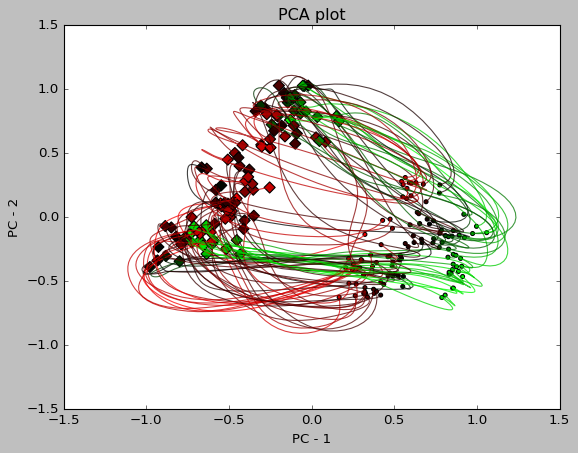

In [22]:
plot_pca_psths(Z, 1, 2, alpha=0.75)

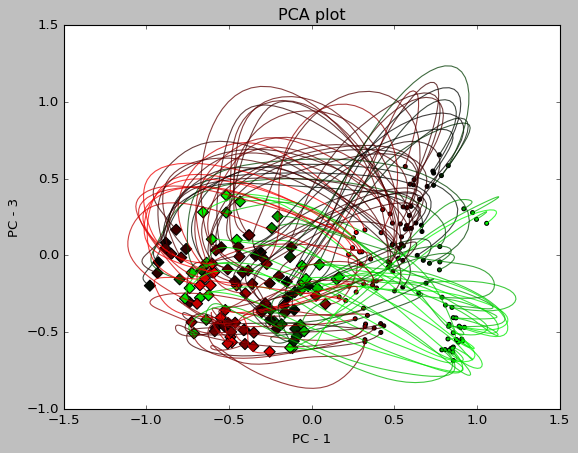

In [23]:
plot_pca_psths(Z, 1, 3, alpha=0.75)

# Exercise 4: Finding the max. likelihood estimate for A

## Log-likelihood and its (naive) gradient

$\Delta z_{t+1} = Az_{t} + \sigma \epsilon_t$ where $\sigma=1$

$\Delta z_{t+1} = N(Az_{t},I_{12\times12})$

$P(\Delta z_{1:T-1} | z_{0:T-1}) = \prod^T_{t=0}N(Az_{t},I_{12\times12})$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = \sum^T_{t=0}log(N(Az_{t},I_{12\times12}))$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = \sum^T_{t=0} log(\exp(-(\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t}))) + const$

$log(P(\Delta z_{1:T} | z_{0:T-1})) = -\sum^T_{t=0} (\Delta z_{t+1} - Az_{t})^TI_{12\times12}(\Delta z_{t+1} - Az_{t}) + const$

$log(P(\Delta Z | Z)) \approx -(\Delta Z - AZ)^T(\Delta Z - AZ) \approx  - Z^TA^TAZ + 2\Delta Z^T A Z$

$\frac{d}{dA}(log(P(\Delta Z | Z))) = -2 AZZ^T + 2\Delta Z Z^T$

##  Parametrising an antisymmetric

K will equal 6, the number of matrix entries above the diagonal

$M \times M = 2K + M$

$K = \frac{M(M-1)}{2}$

In [24]:
beta = np.array([[0.0001, 1, 1, 0.0001, 1, 1]])

def create_h(m):
    k = int( (m**2 - m)/2)
    h = np.zeros((k, m, m))
    row, column = 0, 1
    for i in range(0, k):
        h[i][int(row)][int(column)], h[i][int(column)][int(row)] = 1, -1
        column += 1
        if column >= m:
            row += 1
            column = row + 1
    return h

H = create_h(4)
print(beta.shape)
print(H.shape)
print(H)

A = np.tensordot(beta, H, axes=1)

(1, 6)
(6, 4, 4)
[[[ 0.  1.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0. -1.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  1.]
  [ 0.  0. -1.  0.]]]


# Gradient with respect to β

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a \sum^M_{j=1}H_{a,i,j}Z_{j,n})^T(\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_a\sum^M_{j=1}H_{a,i,j}Z_{j,n})$

$log(P(\Delta Z | Z)) \approx  - (\sum^K_{a=1}\beta_a W_{a,i,n})^T(\sum^K_{a=1}\beta_aW_{a,i,n}) + 2\Delta Z^T (\sum^K_{a=1}\beta_aW_{a,i,n}) = - (\beta W)^T(\beta W) + 2\Delta Z^T (\beta W)$

$\frac{d}{d\beta}(log(P(\Delta Z | Z))) \approx - 2\beta W^TW + 2\Delta Z^T W$

$Q = W^TW$ and $b = \Delta Z^T W$

## An antisymmetric estimate for A

Solve $ \beta = b Q^{-1}$

In [25]:
def a_estimate(z):
    m = z.shape[0]
    z_plus, z_  = z[:,:,1:], z[:,:,:-1]
    z_plus = z_plus.reshape((m, z_plus.shape[1]*z_plus.shape[2]))
    z_ = z_.reshape((m, z_.shape[1]*z_.shape[2]))

    h = create_h(z_.shape[0])
    w = np.tensordot(h, z_, axes=1)
    q = np.tensordot(w, w, axes=([1,2],[1,2]))

    delta_z = z_plus - z_
    b = np.tensordot(delta_z, w, axes=([0,1],[1,2]))
    b = b.reshape((1,66))

    beta = b @ np.linalg.inv(q)
    a = np.tensordot(beta, h, axes=([1],[0]))
    a = a.reshape((m, m))
    return beta, a

In [26]:
beta, A = a_estimate(Z)

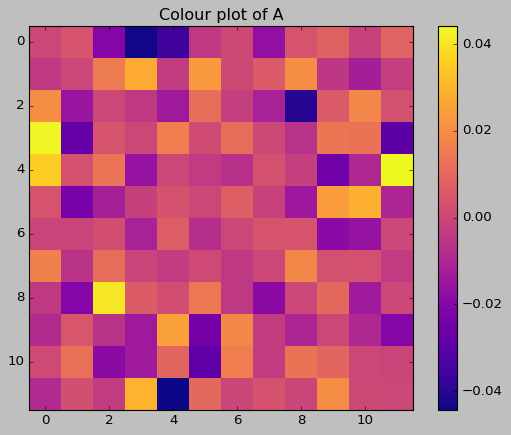

In [27]:
img = plt.imshow(A, interpolation ='nearest', cmap='plasma' )
plt.colorbar(img)
plt.title('Colour plot of A')
plt.show()

## Test

In [28]:
test = np.load('test.npz')
Z_test = test['Z_test']
A_test = test['A_test']

In [29]:
beta_test_estimated, A_test_estimated = a_estimate(Z_test)

In [30]:
A_inaccuracy = (A_test_estimated - A_test)
print(A_inaccuracy.max())

2.6940888755988546e-12


# Exercise 5: 2D projections with rotational dynamics

## A) Eigenvalues and Eigenvectors of A

In [31]:
A_evalue, A_evector = np.linalg.eig(A)
print(A_evalue)

[-2.16840434e-18+0.08774243j -2.16840434e-18-0.08774243j
  1.30104261e-18+0.07696607j  1.30104261e-18-0.07696607j
 -2.49366500e-18+0.04653843j -2.49366500e-18-0.04653843j
  1.08420217e-18+0.02712615j  1.08420217e-18-0.02712615j
  2.05998413e-18+0.01314099j  2.05998413e-18-0.01314099j
 -4.87890978e-19+0.00408012j -4.87890978e-19-0.00408012j]


## B)

In [32]:
def get_p(eigen_vectors, plane):
    evector_real = eigen_vectors[:,plane].real
    evector_imag = eigen_vectors[:,plane].imag
    p = np.zeros((2, 12))
    p[0, :] = evector_real/np.linalg.norm(evector_real)
    p[1, :] = evector_imag/np.linalg.norm(evector_imag)
    print(p[0, :].T @ p[1, :])
    return p

In [33]:
P_FR = get_p(A_evector, 0)

5.672545766444159e-16


## C)

In [34]:
def plot_proj_psths(data1, title, data2=None, alpha=1):
    np.random.seed(41)
    alt_colors = [False, True]

    for index, data in enumerate([data1, data2]):
        if data is not None:
            colors = get_colors(data[0, :, 0], data[1, :, 0], alt_colors[index//2])
            for cond in range(0, data.shape[1]):
                plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=alpha)
                plt.title(title)
                plt.xlabel(f'Axis 1')
                plt.ylabel(f'Axis 2')
            plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
            plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)
        else:
            pass
    plt.show()
    return

In [35]:
Projection_FR = np.tensordot(P_FR, Z, axes=([1],[0]))

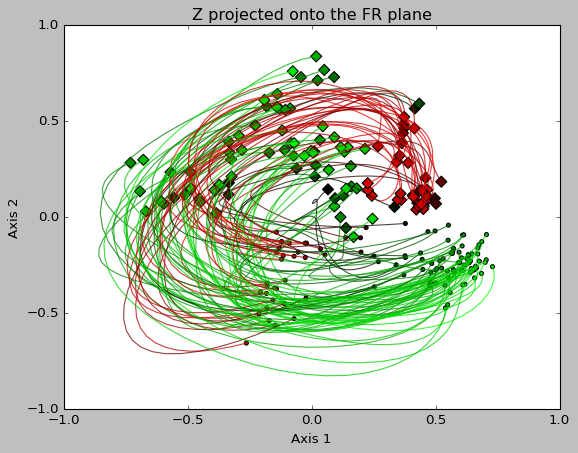

In [36]:
plot_proj_psths(Projection_FR[:, :, 0:36], 'Z projected onto the FR plane', alpha=0.75)

## D)

In [37]:
P_2 = get_p(A_evector, 3)
Projection_2 = np.tensordot(P_2, Z, axes=([1], [0]))
P_3 = get_p(A_evector, 5)
Projection_3 = np.tensordot(P_3, Z, axes=([1], [0]))

-3.469446951953614e-16
-4.3368086899420177e-16


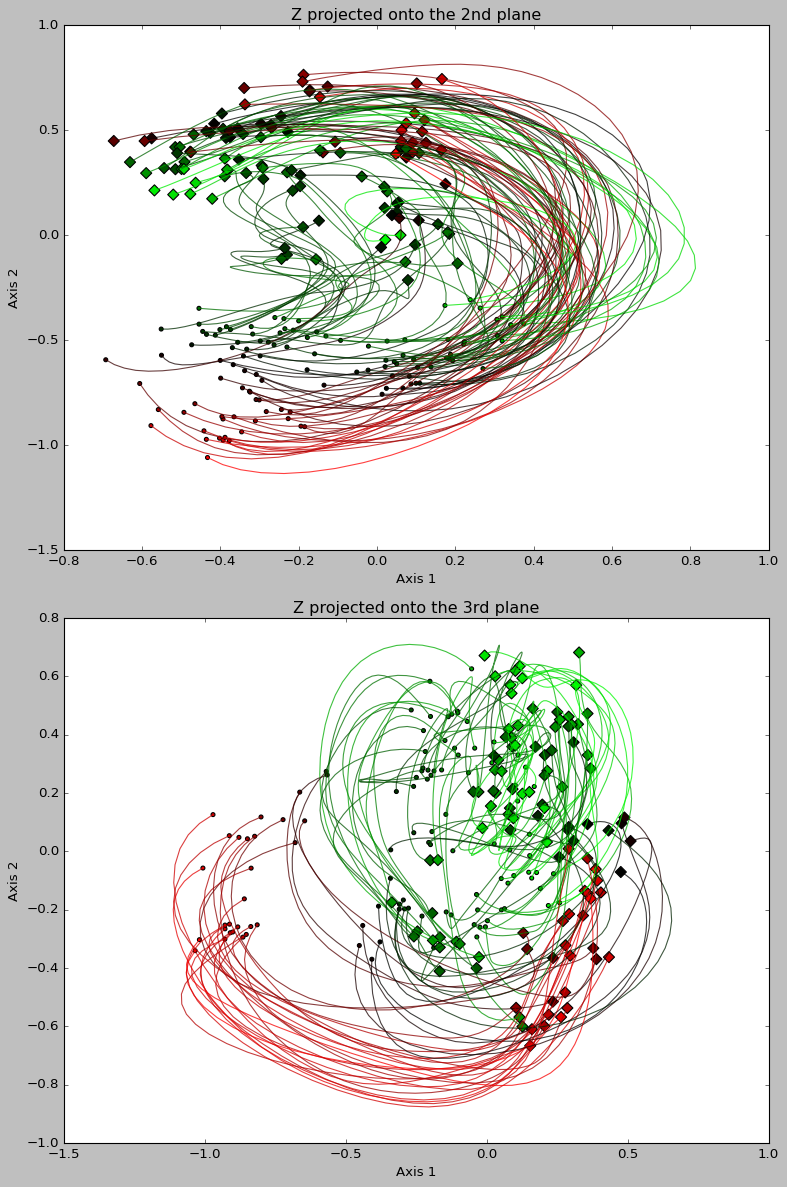

In [38]:
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(10,15))
data1 = Projection_2[:, :, 0:36]
data2 = Projection_3[:, :, 0:36]
colors = get_colors(data1[0, :, 0], data1[1, :, 0])
for cond in range(0, data1.shape[1]):
    ax[0].plot(data1[0, cond, :], data1[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.75)
    ax[0].set_title('Z projected onto the 2nd plane')
    ax[0].set_xlabel(f'Axis 1')
    ax[0].set_ylabel(f'Axis 2')
plot_start(data1[0, :, 0], data1[1, :, 0], colors, markersize=50, ax=ax[0])
plot_end(data1[0, :, -1], data1[1, :, -1], colors, markersize=50, ax=ax[0])

colors = get_colors(data2[0, :, 0], data2[1, :, 0])
for cond in range(0, data2.shape[1]):
    ax[1].plot(data2[0, cond, :], data2[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.75)
    ax[1].set_title('Z projected onto the 3rd plane')
    ax[1].set_xlabel(f'Axis 1')
    ax[1].set_ylabel(f'Axis 2')
plot_start(data2[0, :, 0], data2[1, :, 0], colors, markersize=50, ax=ax[1])
plot_end(data2[0, :, -1], data2[1, :, -1], colors, markersize=50, ax=ax[1])

# Exercise 6: Pre-movement period

In [39]:
X_pre = X_norm_mean[:, :, :66]
X = X_pre.reshape(X_pre.shape[0], X_pre.shape[1] * X_pre.shape[2])
Z_pre = pca.transform(X.T).T
Z_pre = Z_pre.reshape(12 , X_pre.shape[1], X_pre.shape[2])
Projection_FR_pre = np.tensordot(P_FR, Z_pre, axes=([1], [0]))

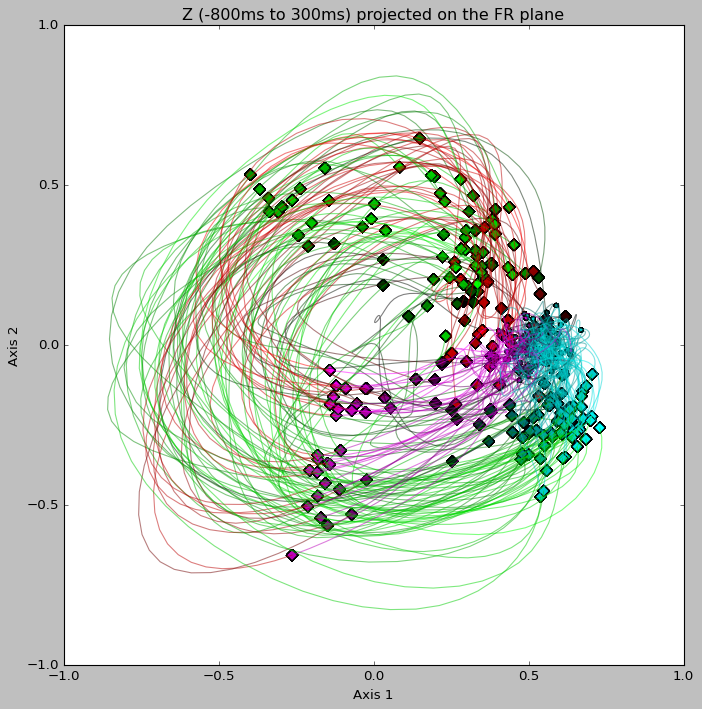

In [40]:
plt.figure(figsize=(10, 10))
data = Projection_FR
colors = get_colors(data[0, :, 0], data[1, :, 0], alt_colors=False)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

data = Projection_FR_pre
colors = get_colors(data[0, :, -1], data[1, :, -1], alt_colors=True)
for cond in range(0, data.shape[1]):
    plt.plot(data[0, cond, :], data[1, cond, :], label = 'C = '+str(cond), color=colors[cond], alpha=0.5)
    plot_start(data[0, :, 0], data[1, :, 0], colors, markersize=50, ax=None)
    plot_end(data[0, :, -1], data[1, :, -1], colors, markersize=50, ax=None)

plt.title('Z (-800ms to 300ms) projected on the FR plane')
plt.xlabel(f'Axis 1')
plt.ylabel(f'Axis 2')

plt.show()

# Exercise 7: Control Analysis

In [41]:
## Load data
X_seven, times = data_orig['X'], data_orig['times']

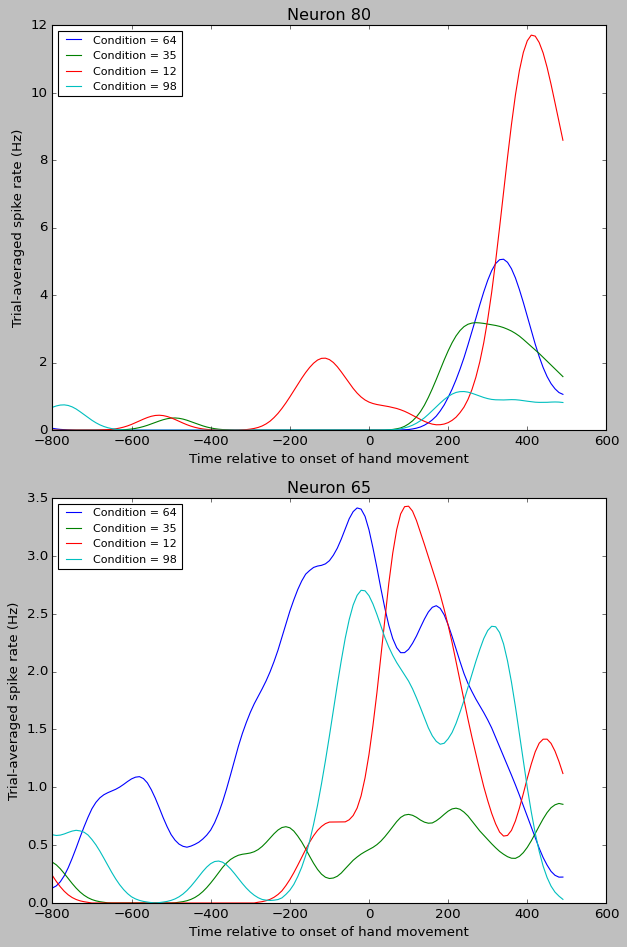

In [42]:
## Plot pre-distortion
plot_psths(X_seven, times, 2, 1, 4)

In [43]:
## Distortion
for N in range(X_seven.shape[0]):
    conditions = np.random.choice(108, (108//2,), replace=False)
    X_seven[N, conditions, 65:] = 2*X_seven[N, conditions, 65].reshape((54,1))- X_seven[N, conditions, 65:]

In [44]:
## Normalising
X_seven_norm = norm_data(X_seven)

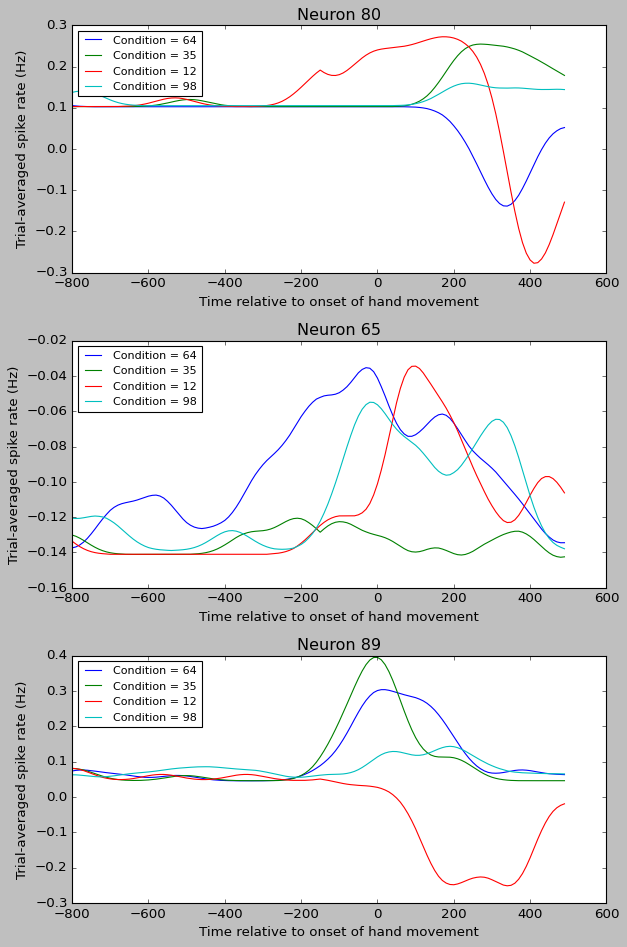

In [45]:
## Mean centering
X_seven_norm_mean = center_data(X_seven_norm)
plot_psths(X_seven_norm_mean, times, 3, 1, 4)

In [46]:
## Dimensionality reduction by PCA
X_seven_trunc = X_seven_norm_mean[:, :, 65:111]
X_seven = X_seven_trunc.reshape(X_seven_trunc.shape[0], X_seven_trunc.shape[1] * X_seven_trunc.shape[2])
pca_seven = PCA(n_components=12)
pca_seven.fit(X_seven.T)
Z = pca_seven.transform(X_seven.T).T

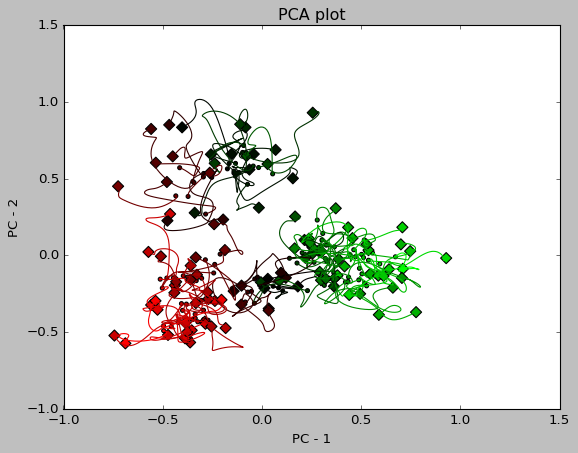

In [47]:
Z = Z.reshape(12, X_trunc.shape[1], X_trunc.shape[2])
plot_pca_psths(Z, 1, 2)

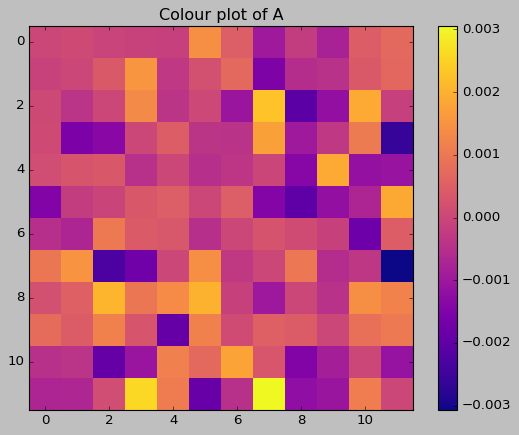

In [48]:
# Exercise 4
beta, A = a_estimate(Z)
img = plt.imshow(A, interpolation ='nearest', cmap='plasma' )
plt.colorbar(img)
plt.title('Colour plot of A')
plt.show()

2.949029909160572e-16


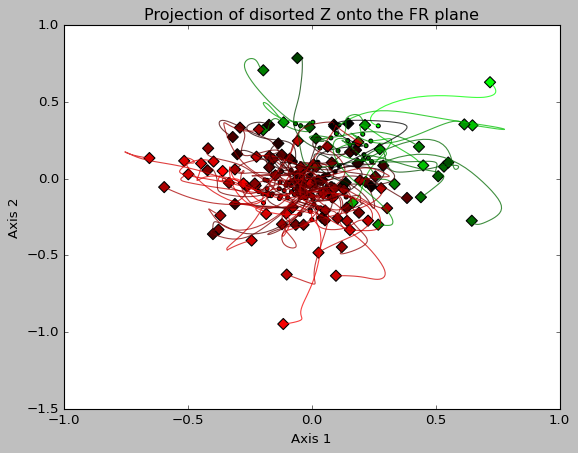

In [49]:
## A)
A_evalue, A_evector = np.linalg.eig(A)

## B)
P_FR = get_p(A_evector, 0)

## C)
Projection_FR = np.tensordot(P_FR, Z, axes=([1], [0]))
plot_proj_psths(Projection_FR[:, :, 0:36], 'Projection of disorted Z onto the FR plane', alpha=0.75)